<a href="https://colab.research.google.com/github/naryst/NER_russian_BERT/blob/master/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# !cp /content/drive/MyDrive/data.zip /content

In [3]:
# !unzip data.zip

In [4]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import os
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch
import torch.nn
from torch.utils.data import Dataset, DataLoader
import torch.optim
from tqdm import tqdm
import torch.nn.functional as F

In [6]:
ROOT_DIR = "train_data/"
texts50 = ROOT_DIR + "50texts_tacred/"
cll3 = ROOT_DIR + "coll3_tacred/"
legal = ROOT_DIR + "legal/"
tacred2 = ROOT_DIR + "tacred2/"
tacred3 = ROOT_DIR + "tacred3/"

In [7]:
def create_dataframe(dir):
    df = pd.DataFrame(columns=["fName", "text", "entities"])
    df = df.set_index("fName")
    files = os.listdir(dir)
    for name in files:
        fname, ext = name.split(".")
        with open(dir + name) as f:
            text = f.read()
        if ext == "txt":
            ann_fname = files[files.index(fname + ".ann")]
            with open(dir + ann_fname) as f_ann:
                entities = f_ann.readlines()
            new_entities = []
            for i in range(len(entities)):
                entity_type = entities[i][0]
                entities[i] = entities[i][:-1]
                if entity_type == "T":
                    entities[i] = entities[i].split("\t")
                    entities[i] = entities[i][1:]
                    src = entities[i][1]
                    entities[i] = entities[i][0].split()
                    entities[i].append(src)
                    assert len(entities[i]) <= 5
                    if len(entities[i]) == 5:
                        begin = entities[i][1]
                        inter1, inter2 = entities[i][2].split(";")
                        end = entities[i][3]
                        new_entities.append(
                            [entities[i][0], begin, inter1, entities[i][4]]
                        )
                        new_entities.append(
                            [entities[i][0], inter2, end, entities[i][4]]
                        )
                    else:
                        new_entities.append(entities[i])
            df.loc[fname] = [text, new_entities]
    return df

In [8]:
df1 = create_dataframe(texts50)
df2 = create_dataframe(cll3)
df3 = create_dataframe(legal)
df4 = create_dataframe(tacred2)
df5 = create_dataframe(tacred3)

In [9]:
df1.shape[0] + df2.shape[0] + df3.shape[0] + df4.shape[0] + df5.shape[0]

841

In [10]:
total_df = pd.concat([df1, df2, df3, df4, df5])

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [12]:
# change the parameter of max tokens what model can process to get tokenization of the whole input
# (not only first 512 tokens, which BERT can process  by its architecture)
tokenizer = AutoTokenizer.from_pretrained(
    "yqelz/xml-roberta-large-ner-russian", model_max_length=int(1.5e4)
)

In [13]:
def identify_tokens(df_sample):
    sample_text = df_sample["text"]
    sample_en = df_sample["entities"]
    sample_text_tokenized = tokenizer.tokenize(sample_text)
    trash_symbols_count = []
    for i in range(len(sample_text)):
        cur = (
            1
            if (
                sample_text[i] == " "
                or sample_text[i] == "\n"
                or sample_text[i] == "\xa0"
            )
            else 0
        )
        if i == 0:
            trash_symbols_count.append(cur)
        else:
            trash_symbols_count.append(trash_symbols_count[-1] + cur)
    cur_entity_id = 0
    processed_symbols = 0
    mappings = []
    begin = int(sample_en[cur_entity_id][1])
    end = int(sample_en[cur_entity_id][2])
    assert end < len(trash_symbols_count)
    begin -= trash_symbols_count[begin]
    end -= trash_symbols_count[end]

    for token in sample_text_tokenized:
        while processed_symbols > end and (cur_entity_id + 1) < len(sample_en):
            cur_entity_id += 1
            begin = int(sample_en[cur_entity_id][1])
            end = int(sample_en[cur_entity_id][2]) - 1
            begin -= trash_symbols_count[begin]
            end -= trash_symbols_count[end]
        if begin <= processed_symbols <= end:
            first_token = not (
                len(mappings) != 0 and sample_en[cur_entity_id] == mappings[-1][1]
            )
            mappings.append((token, sample_en[cur_entity_id], first_token))
        else:
            mappings.append((token, False))
        subword_check = token[0] == "▁"
        processed_symbols = processed_symbols + len(token) - int(subword_check)

    for i in range(len(mappings)):
        if len(mappings[i]) == 2:
            mappings[i] = "O"
        else:
            if mappings[i][-1]:
                mappings[i] = "B-" + mappings[i][1][0]
            else:
                mappings[i] = "I-" + mappings[i][1][0]
    mappings.insert(0, 'O') # start token
    mappings.append('O') # end token
    return mappings

In [14]:
total_df["tokenized_text"] = total_df["text"].apply(tokenizer.tokenize)
total_df["tokenizer_output"] = total_df["text"].apply(
    lambda x: tokenizer(x, return_tensors="pt", padding=True, truncation=True)
)
#add start and end tokens to map tokenizer output
total_df['tokenized_text'] = total_df['tokenized_text'].apply(lambda x: ['START'] + x + ['END'])
total_df["classified_tokens"] = total_df.apply(identify_tokens, axis=1)

In [15]:
total_df.reset_index(inplace=True)
total_df.head()

,fName,text,entities,tokenized_text,tokenizer_output,classified_tokens
0,11899_text,Странное преступление против семьи россиян в А...,"[[NATIONALITY, 35, 42, россиян], [COUNTRY, 45,...","[START, ▁Стран, ное, ▁пре, ступление, ▁против,...","[input_ids, attention_mask]","[O, O, O, O, O, O, O, B-NATIONALITY, O, B-COUN..."
1,112814_text,Квартира Маргарет Тэтчер выставлена на продажу...,"[[FACILITY, 0, 24, Квартира Маргарет Тэтчер], ...","[START, ▁К, вар, тира, ▁Мар, га, рет, ▁Тэ, т, ...","[input_ids, attention_mask]","[O, B-FACILITY, I-FACILITY, I-FACILITY, I-FACI..."
2,106653_text,Хаос и невоспитанные дети: Брэд Питт сравнил с...,"[[PERSON, 27, 36, Брэд Питт], [PERSON, 62, 67,...","[START, ▁Ха, ос, ▁и, ▁не, воспит, а, нные, ▁де...","[input_ids, attention_mask]","[O, O, O, O, O, O, O, O, O, O, B-PERSON, I-PER..."
3,102661_text,Умер Алексей Жарков \n5 июня 2016 года в Москв...,"[[PERSON, 5, 19, Алексей Жарков], [DATE, 21, 3...","[START, ▁У, мер, ▁Алексей, ▁Жар, ков, ▁5, ▁июн...","[input_ids, attention_mask]","[O, O, O, B-PERSON, I-PERSON, I-PERSON, B-DATE..."
4,110637_text,Умер старший представитель дома Романовых княз...,"[[FAMILY, 27, 41, дома Романовых], [PROFESSION...","[START, ▁У, мер, ▁старши, й, ▁представитель, ▁...","[input_ids, attention_mask]","[O, O, O, O, O, O, B-FAMILY, I-FAMILY, I-FAMIL..."


<Axes: >

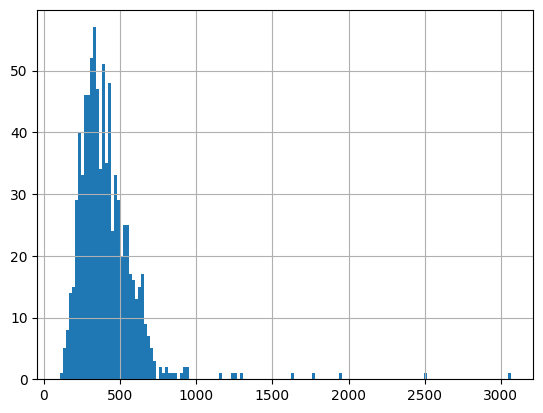

In [16]:
total_df["tokenized_text"].apply(len).hist(bins=150)

In [17]:
lens = total_df["classified_tokens"].apply(len)
print(
    f"Number of samples in train dataset, which have more tokens, when BERT can process - {lens[lens > 512].count() / lens.count() * 100:.3f}%"
)

Number of samples in train dataset, which have more tokens, when BERT can process - 21.284%


Dataset have 21% of samples, what can't be processed by BERT(For example, in document '1109' input text tokenized at more than 3000 tokens). To deal with this problem, we will use sliding window approach. We will split each sample into several samples, each of which will contain 512 tokens. We will use 256 tokens overlap between samples.

In [18]:
total_df["input_ids"] = total_df["tokenizer_output"].apply(lambda x: x["input_ids"])
total_df["attention_mask"] = total_df["tokenizer_output"].apply(
    lambda x: x["attention_mask"]
)

In [19]:
sample = total_df[total_df["fName"] == "1109"]
iids = sample["input_ids"].values[0]
attn = sample["attention_mask"].values[0]

In [20]:
iids.shape, attn.shape, len(sample["tokenized_text"].values[0])

(torch.Size([1, 3065]), torch.Size([1, 3065]), 3065)

In [21]:
# drop useless columns
total_df.drop(["entities", "text", 'tokenizer_output'], axis=1, inplace=True)

In [22]:
# split samples with more than 512 tokens
def split_sample(sample):
    tokenized_text = sample["tokenized_text"]
    classified_entities = sample["classified_tokens"]
    fname = sample["fName"]
    input_ids = sample["input_ids"]
    attention_mask = sample["attention_mask"]
    if input_ids.shape[1] <= 512:
        return pd.DataFrame(
            [[fname, input_ids, attention_mask, tokenized_text, classified_entities]],
            columns=[
                "fName",
                "input_ids",
                "attention_mask",
                "tokenized_text",
                "classified_tokens",
            ],
        )
    else:
        samples = []
        for i in range(0, len(tokenized_text), 256):
            if i + 512 <= len(tokenized_text):
                samples.append(
                    [
                        fname,
                        input_ids[:, i : i + 512],
                        attention_mask[:, i : i + 512],
                        tokenized_text[i : i + 512],
                        classified_entities[i : i + 512],
                    ]
                )
            else:
                samples.append(
                    [
                        fname,
                        input_ids[:, -512:],
                        attention_mask[:, -512:],
                        tokenized_text[-512:],
                        classified_entities[-512:],
                    ]
                )
        return pd.DataFrame(
            samples, columns=["fName", "input_ids", "attention_mask", "tokenized_text", "classified_tokens"]
        )

In [23]:
total_df

,fName,tokenized_text,classified_tokens,input_ids,attention_mask
0,11899_text,"[START, ▁Стран, ное, ▁пре, ступление, ▁против,...","[O, O, O, O, O, O, O, B-NATIONALITY, O, B-COUN...","[[tensor(0), tensor(107722), tensor(5509), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
1,112814_text,"[START, ▁К, вар, тира, ▁Мар, га, рет, ▁Тэ, т, ...","[O, B-FACILITY, I-FACILITY, I-FACILITY, I-FACI...","[[tensor(0), tensor(1382), tensor(7179), tenso...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
2,106653_text,"[START, ▁Ха, ос, ▁и, ▁не, воспит, а, нные, ▁де...","[O, O, O, O, O, O, O, O, O, O, B-PERSON, I-PER...","[[tensor(0), tensor(8639), tensor(9107), tenso...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
3,102661_text,"[START, ▁У, мер, ▁Алексей, ▁Жар, ков, ▁5, ▁июн...","[O, O, O, B-PERSON, I-PERSON, I-PERSON, B-DATE...","[[tensor(0), tensor(447), tensor(6794), tensor...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
4,110637_text,"[START, ▁У, мер, ▁старши, й, ▁представитель, ▁...","[O, O, O, O, O, O, B-FAMILY, I-FAMILY, I-FAMIL...","[[tensor(0), tensor(447), tensor(6794), tensor...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
...,...,...,...,...,...
836,14776_text,"[START, ▁Об, ви, нение, ▁против, ▁Ст, росс, -,...","[O, O, O, O, O, B-PERSON, I-PERSON, I-PERSON, ...","[[tensor(0), tensor(5188), tensor(2827), tenso...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
837,125048_text,"[START, ▁Об, лада, тель, ница, ▁самой, ▁большо...","[O, O, O, O, O, O, O, O, O, B-LOCATION, O, O, ...","[[tensor(0), tensor(5188), tensor(36475), tens...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
838,27246_text,"[START, ▁Ж, итель, ▁Ал, я, ски, ▁стал, ▁самым,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[[tensor(0), tensor(4356), tensor(63354), tens...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
839,37666_text,"[START, ▁В, ▁Кли, вле, нде, ▁обнаружен, ы, ▁тр...","[O, O, B-CITY, I-CITY, I-CITY, O, O, B-NUMBER,...","[[tensor(0), tensor(417), tensor(55155), tenso...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."


In [24]:
total_df = total_df.apply(split_sample, axis=1)

In [25]:
total_df = pd.concat(total_df.values)
total_df.reset_index(inplace=True)
total_df.drop("index", axis=1, inplace=True)

<Axes: >

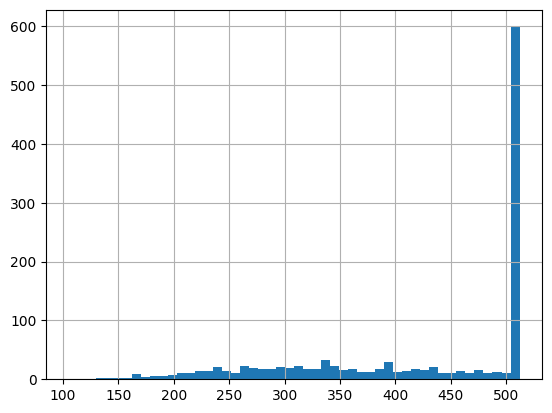

In [26]:
total_df["tokenized_text"].apply(len).hist(bins=50)

In [27]:
# test token mapping for the sample
n = 3
sample = total_df.iloc[n]
sample_tokens = sample["tokenized_text"]
sample_entities = sample["classified_tokens"]
a = np.array([sample_tokens, sample_entities])
a.T

array([['START', 'O'],
       ['▁К', 'B-FACILITY'],
       ['вар', 'I-FACILITY'],
       ['тира', 'I-FACILITY'],
       ['▁Мар', 'I-FACILITY'],
       ['га', 'I-FACILITY'],
       ['рет', 'I-FACILITY'],
       ['▁Тэ', 'I-FACILITY'],
       ['т', 'I-FACILITY'],
       ['чер', 'I-FACILITY'],
       ['▁вы', 'O'],
       ['ставлен', 'O'],
       ['а', 'O'],
       ['▁на', 'O'],
       ['▁продажу', 'O'],
       ['▁в', 'O'],
       ['▁Лондон', 'B-CITY'],
       ['е', 'I-CITY'],
       ['▁Мар', 'B-PERSON'],
       ['га', 'I-PERSON'],
       ['рет', 'I-PERSON'],
       ['▁Тэ', 'I-PERSON'],
       ['т', 'I-PERSON'],
       ['чер', 'I-PERSON'],
       ['▁К', 'B-FACILITY'],
       ['вар', 'I-FACILITY'],
       ['тира', 'I-FACILITY'],
       ['▁бы', 'I-FACILITY'],
       ['вшего', 'I-FACILITY'],
       ['▁премьер', 'I-FACILITY'],
       ['-', 'I-FACILITY'],
       ['министр', 'I-FACILITY'],
       ['а', 'I-FACILITY'],
       ['▁Великобритании', 'I-FACILITY'],
       ['▁Мар', 'I-FACILITY'],
       

In [28]:
unique_entities = []
for sample in total_df["classified_tokens"]:
    for token in sample:
        unique_entities.append(token)
unique_entities = np.unique(unique_entities)

In [29]:
id2label = {}
label2id = {}

for i in range(len(unique_entities)):
    id2label[i] = unique_entities[i]
    label2id[unique_entities[i]] = i

In [30]:
labels_num = len(unique_entities)

In [31]:
labels_num

59

In [32]:
class BertTokenClassification(torch.nn.Module):
    def __init__(self):
        super(BertTokenClassification, self).__init__()
        #transformers.models.xlm_roberta.modeling_xlm_roberta.XLMRobertaForTokenClassification
        self.bert = AutoModelForTokenClassification.from_pretrained("yqelz/xml-roberta-large-ner-russian")
        self.bert.config.id2label = id2label
        self.bert.config.label2id = label2id
        self.bert.num_labels = labels_num
        self.bert.classifier = torch.nn.Linear(1024, labels_num)

    def forward(self, input_id, mask, label):
        output = self.bert(
            input_ids=input_id, attention_mask=mask, labels=label)
        return output

In [33]:
class TextDataset(Dataset):
    def __init__(self, dataframe):
        self.df = dataframe

    def __len__(self):
        return len(self.df)

    @staticmethod
    def df_sample_to_tensor(row):
        data = row['input_ids']
        labels = row['classified_tokens']
        labels = list(map(lambda x: label2id[x], labels))
        labels = torch.tensor(labels)
        data = torch.squeeze(labels)
        # print(labels.shape, data.shape)
        return data, labels

    def __getitem__(self, idx):
        return self.df_sample_to_tensor(self.df.iloc[idx])

In [34]:
#complement input ids and attention mask
#to 512 elements, to bring all tensors to the same shape
def tokenization_complement(tensor):
    complement_size = 512 - tensor.shape[1]
    zeros_complement = torch.zeros((1,complement_size))
    new_sample = torch.cat((tensor, zeros_complement,), dim=1)
    assert new_sample.shape[1] == 512
    return new_sample

#complement labels to the form of tensors
def labels_complement(labels):
    complement_size = 512 - len(labels)
    new_labels = labels
    for i in range(complement_size):
        new_labels.append('O')
    return new_labels

In [35]:
total_df['input_ids'] = total_df['input_ids'].apply(tokenization_complement)
total_df['attention_mask'] = total_df['attention_mask'].apply(tokenization_complement)

In [36]:
total_df['classified_tokens'] = total_df['classified_tokens'].apply(labels_complement)

In [37]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(total_df, train_size=0.9)

In [38]:
BATCH_SIZE = 2
lr = 3e-4
EPOCH_NUMBER = 3

def train_loop(model, train_d, val_d, epoch_num=EPOCH_NUMBER):
    train_dataset = TextDataset(train_d)
    val_dataset = TextDataset(val_d)

    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []

    for epoch in range(epoch_num):
        acc_train = 0
        cur_loss_train = 0
        acc_val = 0
        loss_val = 0

        model.train()
        for data, labels in tqdm(train_dataloader):
            attention_mask = (data != 0).float().to(device)
            data = data.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            output = model(data, attention_mask, labels)
            loss, logits = output[0], output[1]
            # print(logits.shape)
            # break
            for i in range(logits.shape[0]):
                predictions = logits.argmax(dim=2)
                acc = (predictions == labels).float().mean()
                acc_train += acc
                cur_loss_train += loss.item()
            
            loss.backward()
            optimizer.step()

        model.eval()
        for data, labels in tqdm(val_dataloader):
            attention_mask = (data != 0).float().to(device)
            data = data.to(device)
            labels = labels.to(device)
            output = model(data, attention_mask, labels)
            loss, logits = output[0], output[1]
            for i in range(logits.shape[0]):
                predictions = logits.argmax(dim=2)
                acc = (predictions == labels).float().mean()
                acc_val += acc
                loss_val += loss.item()
        
        print(f'Epochs: {epoch + 1} | train Loss: {cur_loss_train / len(train_d): .3f} | train Accuracy: {acc_train / len(train_d): .3f}')
        print(f'val Loss: {loss_val / len(val_d): .3f} | train Accuracy: {acc_val / len(val_d): .3f}')



In [39]:
torch.cuda.empty_cache()

In [40]:
model = BertTokenClassification().to(device)

In [41]:
train_loop(model, train_data, val_data)

100%|██████████| 63/63 [00:14<00:00,  4.40it/s]


Epochs: 1 | train Loss:  1.282 | train Accuracy:  0.764
val Loss:  1.168 | train Accuracy:  0.785


100%|██████████| 63/63 [00:14<00:00,  4.40it/s]


Epochs: 2 | train Loss:  1.246 | train Accuracy:  0.767
val Loss:  1.163 | train Accuracy:  0.785


100%|██████████| 63/63 [00:14<00:00,  4.40it/s]

Epochs: 3 | train Loss:  1.242 | train Accuracy:  0.767
val Loss:  1.171 | train Accuracy:  0.785


In [45]:
test_dir = 'test_data/'

In [58]:
texts = []
f_names = []
for file_name in os.listdir(test_dir):
    file_path = test_dir + file_name
    # print(file_name)
    if file_name.split('.')[1] == 'txt':
        with open(file_path) as f:
            cur_text = f.read()
        texts.append(cur_text)
        f_names.append(file_name)

test_df = pd.DataFrame({'fName': f_names, 'text' : texts})

In [62]:
test_df['tokenized_text'] = test_df['text'].apply(tokenizer.tokenize)

In [68]:
test_df['tokenized_text'] = test_df['tokenized_text'].apply(lambda x: ['START'] + x + ['END'])

<Axes: >

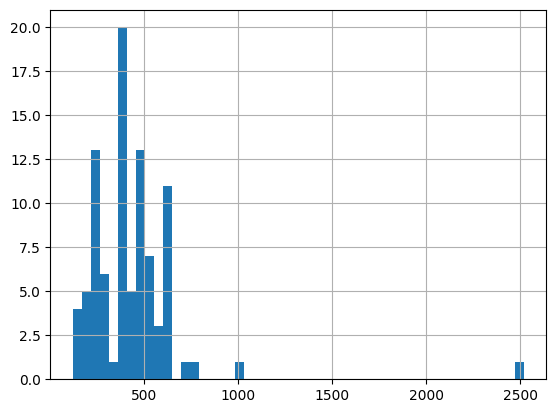

In [73]:
test_df['tokenized_text'].apply(len).hist(bins=50)

In [74]:
test_df["tokenizer_output"] = test_df["text"].apply(
    lambda x: tokenizer(x, return_tensors="pt", padding=True, truncation=True)
)

In [76]:
test_df

,fName,text,tokenized_text,tokenizer_output
0,187827_text.txt,Bellingcat и The Insider: Александр Петров — в...,"[START, ▁Bell, ing, cat, ▁и, ▁The, ▁Insider, :...","[input_ids, attention_mask]"
1,1136.txt,"Медалью ордена ""За заслуги перед Чувашской Рес...","[START, ▁Ме, даль, ю, ▁орден, а, ▁"", За, ▁засл...","[input_ids, attention_mask]"
2,185911_text.txt,Нобелевский лауреат «случайно» поддержал повыш...,"[START, ▁Но, бел, евски, й, ▁лауреат, ▁«, слу,...","[input_ids, attention_mask]"
3,193267_text.txt,Сборная России победила на чемпионате мира по ...,"[START, ▁С, бор, ная, ▁России, ▁победи, ла, ▁н...","[input_ids, attention_mask]"
4,180710_text.txt,Джон Маккейн отказался от дальнейшего лечения ...,"[START, ▁Джон, ▁Мак, ке, йн, ▁отказа, лся, ▁от...","[input_ids, attention_mask]"
...,...,...,...,...
87,187083_text.txt,Нобелевскую премию мира вручили за борьбу с се...,"[START, ▁Но, беле, в, скую, ▁прем, ию, ▁мира, ...","[input_ids, attention_mask]"
88,548033_text.txt,Билл Гейтс покинул совет директоров Microsoft\...,"[START, ▁Бил, л, ▁Ге, йт, с, ▁поки, нул, ▁сове...","[input_ids, attention_mask]"
89,192238_text.txt,Полноценная встреча Трампа с Путиным не состои...,"[START, ▁Пол, но, цен, ная, ▁встреча, ▁Трампа,...","[input_ids, attention_mask]"
90,1167.txt,"\nПреемника Марины Лошак на должности главы ""М...","[START, ▁Пре, ем, ника, ▁Марин, ы, ▁Ло, шак, ▁...","[input_ids, attention_mask]"


In [100]:
def model_inference(text):
    trash_symbols_count = []
    for i in range(len(text)):
        is_trash_symbol = 1 if (text[i] == "\n" or text[i] == "\xa0") else 0
        if i == 0:
            trash_symbols_count.append(is_trash_symbol)
        else:
            trash_symbols_count.append(trash_symbols_count[i-1] + is_trash_symbol)
    
    tokens = tokenizer.tokenize(text)
    token_ids, attention_mask = tokenizer(text)

    processed_symbols = -1 # cause of _ before the first token
    for token in tokens:
        begin = processed_symbols if processed_symbols >= 0 else 0
        processed_symbols += len(token)
        end = processed_symbols - trash_symbols_count[processed_symbols]
        print(text[begin: end], ' ---- ', token, '(', begin, ' ', end, ')')


In [101]:
sample_text = test_df['text'].iloc[0]
model_inference(sample_text)
sample_text

Bell  ----  ▁Bell ( 0   4 )
ing  ----  ing ( 4   7 )
cat  ----  cat ( 7   10 )
 и  ----  ▁и ( 10   12 )
 The  ----  ▁The ( 12   16 )
 Insider  ----  ▁Insider ( 16   24 )
:  ----  : ( 24   25 )
 Александр  ----  ▁Александр ( 25   35 )
 Петров  ----  ▁Петров ( 35   42 )
 —  ----  ▁— ( 42   44 )
 во  ----  ▁во ( 44   47 )
енный  ----  енный ( 47   52 )
 врач  ----  ▁врач ( 52   57 )
 Г  ----  ▁Г ( 57   59 )
РУ  ----  РУ ( 59   61 )
 Александр  ----  ▁Александр ( 61   71 )
 Миш  ----  ▁Миш ( 71   75 )
ки  ----  кин ( 75   77 )

П  ----  ▁По ( 78   80 )
лице  ----  лицей ( 81   85 )
ска  ----  ская ( 86   89 )
 пала  ----  ▁палат ( 90   95 )
к  ----  ка ( 96   97 )
 на  ----  ▁над ( 98   101 )
 мест  ----  ▁место ( 102   107 )
  ----  м ( 108   108 )
 гд  ----  ▁где ( 109   112 )
 был  ----  ▁были ( 113   117 )
 обнаруже  ----  ▁обнаружен ( 118   127 )
  ----  ы ( 128   128 )
 о  ----  ▁от ( 129   131 )
ра  ----  рав ( 132   134 )
ле  ----  лен ( 135   137 )
ны  ----  ные ( 138   140 )
 Сер

'Bellingcat и The Insider: Александр Петров — военный врач ГРУ Александр Мишкин\nПолицейская палатка над местом где были обнаружены отравленные Сергей и Юлия Скрипаль\nBellingcat ( ) и The Insider ( ) опубликовали часть совместного расследования, в котором утверждается, что под именем «Александр Петров», которого британские следователи обвиняют в отравлении в Солсбери разведчика Сергея Скрипаля и его дочери Юлии, скрывается военный врач ГРУ Александр Мишкин.\nИздание публикует скан его оригинального паспорта.\n\nРанее Bellingcat и The Insider назвали имя первого подозреваемого в отравлении Скрипалей.\nПо их данным под именем «Руслан Боширов» скрывается 39-летний полковник ГРУ Герой России Анатолий Чепига.\nЭта информация впоследствии косвенно подтвердилась другими СМИ.\n\nИздания утверждают, что Мишкин родился 13 июля 1979 года в селе Лойга в Архангельской области.\n\nОн получил медицинское образование в «одной из военных академий».\nЯкобы во время обучения ему предложили работать в ГР